In [7]:
import torch

BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 10 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '../data/rcnn/training'
# validation images and XML files directory
VALID_DIR = '../data/rcnn/testing'

# classes: 0 index is reserved for background
CLASSES = [
    'background', 'abw', 'pbw'
]
NUM_CLASSES = 3

# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False

# location to save model and plots
OUT_DIR = '../results/rcnn'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

In [8]:
import albumentations as A
import cv2
import numpy as np

from albumentations.pytorch import ToTensorV2

# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

ImportError: cannot import name 'PILLOW_VERSION' from 'PIL' (/usr/local/Caskroom/miniforge/base/envs/vision-next/lib/python3.9/site-packages/PIL/__init__.py)

In [111]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [112]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

# define the negative sample transforms
def get_negative_sample_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ])

In [113]:
def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [114]:
import torch
import cv2
import numpy as np
import os
import glob as glob
import pandas as pd

from torch.utils.data import Dataset, DataLoader

In [115]:
# the dataset class
class WormDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms, negative_sample_transforms):
        self.transforms = transforms
        self.negative_sample_transforms = negative_sample_transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*[jpg|jpeg]")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annotations_file = image_name.split('.')[0] + '.txt'
        annotations_file_path = os.path.join(self.dir_path, annotations_file)
        
        boxes = []
        labels = []
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given

        bounding_boxes_df = pd.read_csv(annotations_file_path, sep='\t', names=["target", 'xmin', 'ymin', 'xmax', 'ymax'])
        bounding_boxes_df['xmin'] = bounding_boxes_df['xmin'] * self.width
        bounding_boxes_df['xmax'] = bounding_boxes_df['xmax'] * self.width
        bounding_boxes_df['ymin'] = bounding_boxes_df['ymin'] * self.height
        bounding_boxes_df['ymax'] = bounding_boxes_df['ymax'] * self.height
        
        # bounding box to tensor
        boxes = bounding_boxes_df[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        labels = bounding_boxes_df['target'].to_numpy()
        
        is_negative_sample = len(boxes) == 0

        if is_negative_sample:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.as_tensor(np.array([0]), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # labels to tensor
            labels = torch.as_tensor(labels, dtype=torch.int64)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if not is_negative_sample:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        elif is_negative_sample:
            sample = self.negative_sample_transforms(image=image_resized,
                                                     labels = labels)
            image_resized = sample['image']
        
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

In [116]:
# prepare the final datasets and data loaders
train_dataset = WormDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform(), get_negative_sample_transform())
valid_dataset = WormDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform(), get_negative_sample_transform())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 8763
Number of validation samples: 2803



In [117]:
# # sanity check of the Dataset pipeline with sample visualization
# dataset = WormDataset(
#     TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
# )
# print(f"Number of training images: {len(dataset)}")

# # function to visualize a single sample
# def visualize_sample(image, target):
#     box = target['boxes'][0] if len(target['boxes']) > 0 else []
#     label = CLASSES[target['labels'][0]] if len(target['labels']) > 0 else []
#     if len(box) != 0:
#         cv2.rectangle(
#             image, 
#             (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
#             (0, 255, 0), 1
#         )
#         cv2.putText(
#             image, label, (int(box[0]), int(box[1]-5)), 
#             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
#         )
#     cv2.imshow('Image', image)
#     cv2.waitKey(0)
    
# NUM_SAMPLES_TO_VISUALIZE = 5
# for i in range(NUM_SAMPLES_TO_VISUALIZE):
#     image, target = dataset[i]
#     visualize_sample(image, target)

In [118]:
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights

def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [119]:
from tqdm.auto import tqdm

import torch
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')

In [126]:
# function for running training iterations
def train(train_data_loader, model, optimizer, train_loss_hist, train_loss_list):
    print('Training')
    
    for i, data in enumerate(train_data_loader):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()
    
        # update the loss value beside the progress bar for each iteration
        print(f"Loss: {loss_value:.4f} ,Index: {i}, Total: {len(train_data_loader)}")
    return train_loss_list

In [127]:
# function for running validation iterations
def validate(valid_data_loader, model, val_loss_hist, val_loss_list):
    print('Validating')
    
    for i, data in enumerate(valid_data_loader):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        # update the loss value beside the progress bar for each iteration
        print(f"Loss: {loss_value:.4f} ,Index: {i}, Total: {len(valid_data_loader)}")
    return val_loss_list


EPOCH 1 of 100
Training
Loss: 5.6582 ,Index: 0, Total: 2191
Loss: 1.5755 ,Index: 1, Total: 2191
Loss: 0.7349 ,Index: 2, Total: 2191
Loss: 1.1028 ,Index: 3, Total: 2191
Loss: 1.2336 ,Index: 4, Total: 2191
Loss: 0.5236 ,Index: 5, Total: 2191
Loss: 0.6207 ,Index: 6, Total: 2191
Loss: 1.2364 ,Index: 7, Total: 2191
Loss: 0.8535 ,Index: 8, Total: 2191
Loss: 1.0450 ,Index: 9, Total: 2191
Loss: 0.6522 ,Index: 10, Total: 2191
Loss: 0.7553 ,Index: 11, Total: 2191
Loss: 0.6423 ,Index: 12, Total: 2191
Loss: 1.8567 ,Index: 13, Total: 2191
Loss: 1.6313 ,Index: 14, Total: 2191
Loss: 1.2320 ,Index: 15, Total: 2191
Loss: 0.4457 ,Index: 16, Total: 2191
Loss: 0.9758 ,Index: 17, Total: 2191
Loss: 0.2683 ,Index: 18, Total: 2191
Loss: 0.9132 ,Index: 19, Total: 2191
Loss: 0.7496 ,Index: 20, Total: 2191
Loss: 0.4633 ,Index: 21, Total: 2191
Loss: 0.8835 ,Index: 22, Total: 2191
Loss: 0.5029 ,Index: 23, Total: 2191
Loss: 0.5026 ,Index: 24, Total: 2191
Loss: 0.7628 ,Index: 25, Total: 2191
Loss: 0.8101 ,Index: 26

KeyboardInterrupt: 

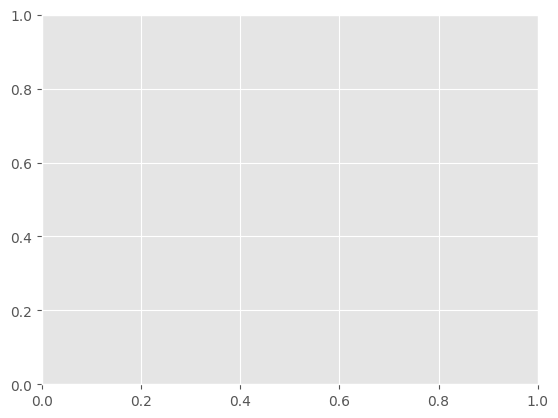

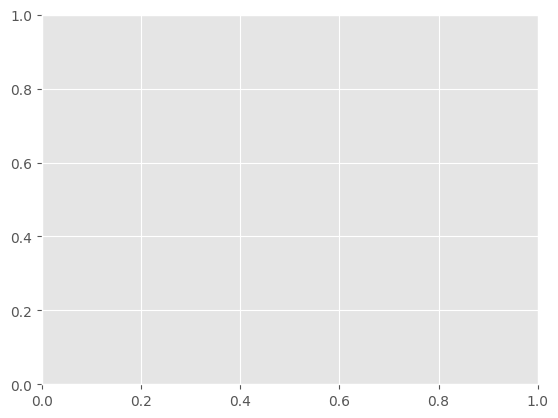

: 

In [128]:
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'rcnn'

# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
    show_tranformed_image(train_loader)

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model, optimizer, train_loss_hist, train_loss_list)
    val_loss = validate(valid_loader, model, val_loss_hist, val_loss_list)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')
    
    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')
    
    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
    
    plt.close('all')

In [ ]:
import numpy as np
import cv2
import torch
import glob as glob

# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(
    '../outputs/model10.pth', map_location=device
))
model.eval()

In [ ]:
# directory where all the images are present
DIR_TEST = '../data/rcnn/training/'
test_images = glob.glob(f"{DIR_TEST}/*")
print(f"Test instances: {len(test_images)}")

# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.6

In [ ]:
results = []
for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            cv2.putText(orig_image, pred_classes[j], 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                        2, lineType=cv2.LINE_AA)
            results.append({
                "image": test_images[i].split('/')[-1],
                "bounding_box": box,
                "prediction": pred_classes[j]
            })

        # cv2.imshow('Prediction', orig_image)
        # cv2.waitKey(1)
        cv2.imwrite(f"../results/test_predictions/{image_name}.jpg", orig_image,)
    print(f"Image {i+1} done...")
    print('-'*50)